## Importing libraries

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from pathlib import Path
%matplotlib inline

## Reading and preparing data

In [2]:
df = pd.read_csv('../data/car_prices.csv')

shape of the dataframe

In [3]:
df.shape

(11914, 16)

First 5 rows

In [4]:
df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


Now, we will lowercase all column names and replace white spaces with underscores / do the same for values in all string columns of the dataframe.

In [7]:
df.columns = df.columns.str.lower().str.replace(' ','_')
string_columns = list(df.dtypes[df.dtypes == 'object'].index)

for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ','_')

In [8]:
df.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,bmw,1_series_m,2011,premium_unleaded_(required),335.0,6.0,manual,rear_wheel_drive,2.0,"factory_tuner,luxury,high-performance",compact,coupe,26,19,3916,46135
1,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,convertible,28,19,3916,40650
2,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,high-performance",compact,coupe,28,20,3916,36350
3,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,coupe,28,18,3916,29450
4,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,luxury,compact,convertible,28,18,3916,34500


## Target Variable Analysis

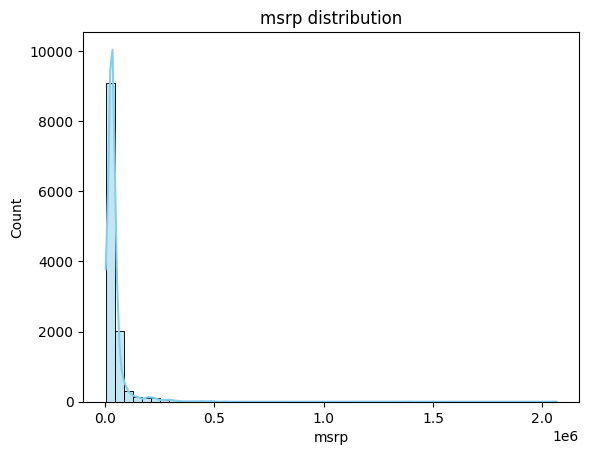

In [14]:
sns.histplot(df.msrp,kde=True,bins = 50,color = 'skyblue',edgecolor='black')
plt.title('msrp distribution')
plt.xlabel('msrp')
plt.ylabel('Count')
plt.savefig('../plots/msrp_distribution.png',dpi=300)
plt.show()

We see so many values at the low end of the price axis and almost nothing at the high end.

Now let's zoom a bit and look at values below 100k $

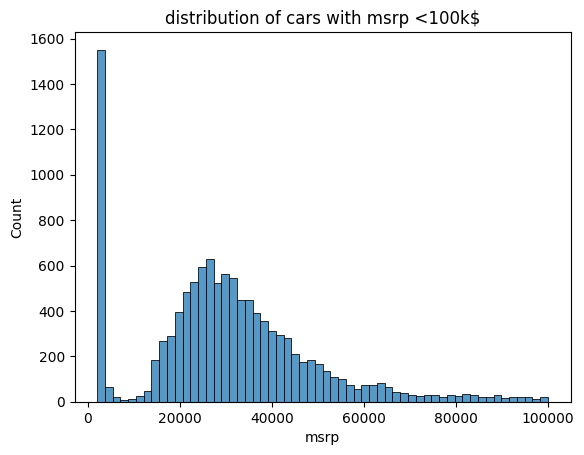

In [28]:
sns.histplot(df.msrp[df.msrp < 100000],kde = False)
plt.title('distribution of cars with msrp <100k$')
plt.savefig('../plots/msrp_distribution_less_100k$.png',dpi=300)
plt.show()

The long tail makes it quite difficult for us to see the distribution, such distribution can greately confuse the model so we will apply the log transformation to the prices

In [29]:
log_price = np.log1p(df.msrp)

here we used y_new = log(1+y) to deal with null values (the +1 part is important to make sure the transformed values do not go below zero)

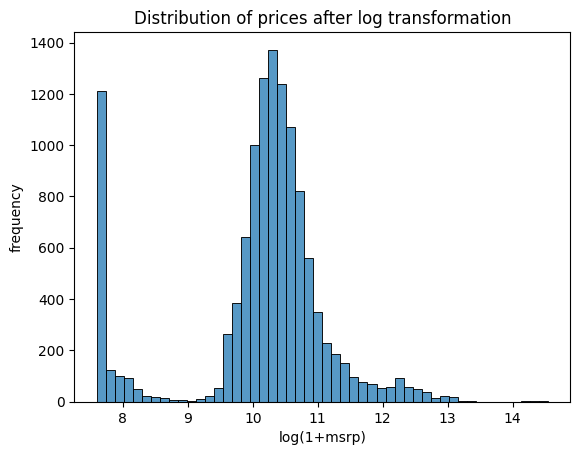

In [35]:
sns.histplot(log_price,kde=False,bins = 50)
plt.xlabel('log(1+msrp)')
plt.ylabel('frequency')
plt.title('Distribution of prices after log transformation')
plt.savefig('../plots/log(1+msrp).png')
plt.show()

Applying the log transformation compresses the tail (reduces the visual dominance of outliers) and makes small differences in low-value regions visible.

## Checking For missing values

In [32]:
df.isnull().sum()

make                    0
model                   0
year                    0
engine_fuel_type        3
engine_hp              69
engine_cylinders       30
transmission_type       0
driven_wheels           0
number_of_doors         6
market_category      3742
vehicle_size            0
vehicle_style           0
highway_mpg             0
city_mpg                0
popularity              0
msrp                    0
dtype: int64

we have around 4000 missing values in market_category column, which we will deal with them later.

## splitting data into validation, test and training sets

In [36]:
n = len(df)

n_val = int(0.2*n)
n_test = int(0.2*n)
n_train = n - (n_val + n_test)

np.random.seed(2) # fixing the random seed
idx = np.arange(n) # creating an array with indices 0->n-1 and shuffle it
np.random.shuffle(idx) 

df_shuffled = df.iloc[idx] # use the array with indices to get a shuffled dataframe

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

Now the dataframe is split into three parts, we will then apply the log transformation for each part to remove the effect of the long tail.

In [37]:
y_train = np.log1p(df_train.msrp.values)
y_val = np.log1p(df_val.msrp.values)
y_test = np.log1p(df_test.msrp.values)

To avoid accidentally using the target variable, let's remove it from the dataframes

In [38]:
del df_train['msrp']
del df_val['msrp']
del df_test['msrp'] 

Exporting the dataframes

In [39]:
df_train.to_pickle('../data/processed/df_train.pkl')
df_test.to_pickle('../data/processed/df_test.pkl')
df_val.to_pickle('../data/processed/df_val.pkl')

In [43]:
save_path = Path('../data/processed/')
with open(save_path / 'y_train.pkl','wb') as f:
    pickle.dump(y_train,f)
with open(save_path / 'y_test.pkl','wb') as f:
    pickle.dump(y_test,f)
with open(save_path / 'y_val.pkl','wb') as f:
    pickle.dump(y_val,f)